# Αυτοκωδικοποιητές

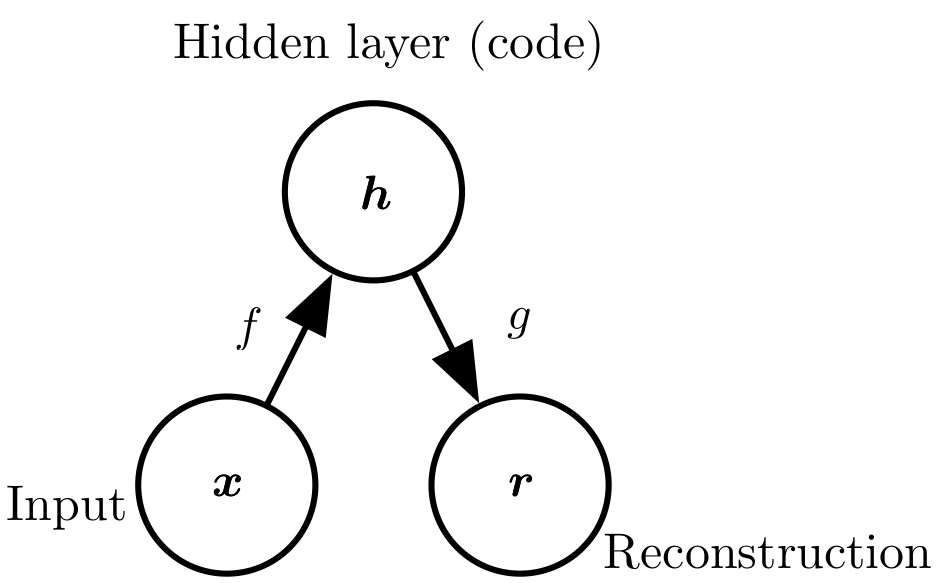

Όπως είπαμε και στη διάλεξη, οι **αυτοκωδικοποιητές** (*autoencoders*) είναι νευρωνικά δίκτυα τα οποία εκπαιδεύονται στο να αντιγράφουν την είσοδό τους στην έξοδό τους. Εσωτερικά αποτελούνται από κρυφό επίπεδο $\mathbf{h}$, στο οποίο αναπαρίσταται (κωδικοποιείται) η είσοδος, ενώ το δίκτυο περιλαμβάνει δύο μέρη:
1. τη συνάρτηση **κωδικοποίησης** (*encoder function*) $\mathbf{h} = f(x)$
1. τη συνάρτηση **αποκωδικοποίησης** (*decoder function*) $\mathbf{r} = g(\mathbf{h})$


Η εκπαίδευση τους πραγματοποιείται είτε μέσω τεχνικών οπίσθιας διάδωσης του σφάλματος (backpropagation) είτε μέσω **επανακυκλοφορίας** (recirculation), όπου συγκρίνεται η ενεργοποίηση των νευρώνων στην αρχική είσοδο και στην αναπαράσταση. Σε αυτό το notebook, οι εκπαιδεύση των δικτύων που θα δούμε βασίζεται στην πρώτη τεχνική.

Οι αυτοκωδικοποιητές παρουσιάστηκαν για πρώτη φορά στα μέσα της δεκαετίας του 1980. Αν και η λειτουργία τους προσομοιάζει αρκετά με τους **απωλεστικούς αλγορίθμους συμπίεσης** (*lossy compresion algorithms*) όπως θα δούμε στη συνέχεια, χρησιμοποιούνται κυρίως σε προβλήματα **μείωσης διαστατικότητας** (*dimensionality reduction*) και **εξαγωγής χαρακτηριστικών** (*feature extraction*).

## Εισαγωγή


### Εγκατάσταση Βιβλιοθηκών


Αρχικά εγκαθιστούμε τις βιβλιοθήκες που πρόκειται να χρησιμοποιήσουμε (*keras*, *numpy* , *matplotlib* και *pandas*)

In [67]:
!pip install --upgrade keras
!pip install --upgrade numpy
!pip install --upgrade matplotlib
!pip install --upgrade pandas

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.1)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


### Εισαγωγή Βιβλιοθηκών

Στη συνέχεια εισάγουμε τις κλάσεις και τις μεθόδους που πρόκειται να χρησιμοποιήσουμε. Επίσης για να μπορούμε να αναπαράξουμε τα αποτελέσματα που θα λάβουμε, αρχικοποιούμε τη γεννήτρια ψευδοτυχαίων αριθμών χρησιμοποιώντας την ίδια σπορά (εδώ τον αριθμό $2019$).

In [0]:
from keras import regularizers
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Seed the pseudo-random number generator with a fixed seed for reproducible
# results
np.random.seed(2019)

### Ορισμός συναρτήσεων

Ορίζουμε δύο συναρτήσεις (μεθόδους) που πρόκεται να χρησιμοποιήσουμε για την παρουσίαση των αποτελεσμάτων, την *compare_digits()* και την *display_digits()*

In [0]:
def compare_digits(test, decoded, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
  
  
def display_digits(data, n=10):
  plt.figure(figsize=(20, 2))
  for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

## Δεδομένα

Για να κατανοήσουμε καλύτερα τη λειτουργία των αυτοκωδικοποιητών, θα χρησιμοποιήσουμε το (γνώστό σε προβλήματα βαθιάς μηχανικής μάθησης) dataset [MNIST,](http://yann.lecun.com/exdb/mnist/), το οποίο περιέχει $70.000$ σκαναρισμένες εικόνες ψηφίων που αντιστοιχούν στους αριθμούς $0$ ως $9$, όπως αυτοί έχουν γραφτεί από διαφορετικούς ανθρώπους.

Η κάθε εικόνα έχει μέγεθος $28\times28$ pixels και είναι ασπρόμαυρη. Επιπλέον, οι δημιουργοί του dataset τις έχουν χωρίσει σε δύο συνόλα, στο σύνολο εκπαίδευσης (που περιέχει $60.000$ εικόνες) και στο σύνολο ελέγχου (που περιέχει $10.000$ εικόνες). 

Μιας και το MNIST dataset παρέχεται (και) μέσω του keras, το φορτώνουμε μέσω αυτής της βιβλιοθήκης. Κατόπιν μετρατρέπουμε την διδιάστατη εικόνα σε ένα διάνυσμα $784$ χαρακτηριστικών και τέλος μετασχηματίζουμε γραμμικά τις τιμές των pixels από το $[0,255]$ στο $[0,1]$ μέσω της κλάσης *MinMaxScaler* του scikit-learn.

In [70]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Υποπλήρης αυτοκωδιοποιητής

Σύμφωνα με τα όσα είπαμε στη διάλεξη,  κατά την εκπαίδευση των αυτοκωδικοποιητών δεν μας ενδιαφέρει τόσο η διαδικασία της αντιγραφής, όσο το να μάθει το δίκτυο να εξάγει και να απωτυπώνει στο επίπεδο κωδικοποίησης ($\mathbf{h}$) χρήσιμες ιδιότητες του χώρου εισόδου ($\mathbf{x}$). Έναςτρόπος για να αποτρέπουμε το δίκτυο από το να μάθει απλά να αντιγράφει την είσοδό του στην έξοδό του είναι να επιβάλλουμε τον περιορισμό η διάσταση της κωδικοποίησης να είναι μικρότερη της διάστασης της εισόδου ($\dim(\mathbf{h}) < \dim(\mathbf{x}))$, κατασκευάζοντας κατ' αυτόν τον τρόπο τους **υποπλήρεις αυτοκωδικοποιητές** (*underbomplete autoencoders*)

Στο παράδειγμα που εξετάζουμε, η διάσταση της εισόδου είναι $28\times28 = 784$ χαρακτηριστικά. Θα την περιορίσουμε (αυαθίρετα) στα $32$ (επιτυγχάνοντας ένα λόγο συμπίεσης $24.5$)

In [0]:
dim_x = 28*28
dim_h = 32

Επιλέγουμε για συνάτηση κωδικοποίησης την [Rectified Linear Unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) και για συνάρτηση αποκωδικοποίησης τη [σιγμοειδή](https://en.wikipedia.org/wiki/Sigmoid_function).  Έτσι η συνάρτηση κωδικοποίησης γίνεται $f(\mathbf{x}) = \max(0, \mathbf{w}_e\mathbf{x} + \mathbf{b}_e)$ και η συνάρτηση απόκωδικοποίησης $g(\mathbf{h}) = S(\mathbf{w}_d\mathbf{h} + \mathbf{b}_d)$. Κατά τη διάρκεια της εκπαίδευσης (που πραγματοποιείται με τη μέθοδο Anadelta), το δίκτυο μαθαίνει τα βάρη ($\mathbf{w}_e, \mathbf{w}_d$) και τις πολώσεις ($\mathbf{b}_e, \mathbf{b}_d$). Τέλος, η συνάρτηση σφάλματος που βελτιστοποιείται είναι η [δυαδική διαστραυρούμενη εντροπία](https://en.wikipedia.org/wiki/Cross_entropy)

In [0]:
autoencoder = Sequential([
    Dense(dim_h, activation='relu', input_shape=(dim_x,)),
    Dense(dim_x, activation='sigmoid')
])


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Εκπαιδεύουμε το δίκτυο που ορίσαμε προηγουμένως για 50 εποχές και με batch size 64. Προσέξτε ότι, μιας και πρόκειται για αυτοκωδικοποιητή, η είσοδος και η έξοδος ταυτίζονται (x_train).

In [73]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.2758 - val_loss: 0.2161
Epoch 2/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.1970 - val_loss: 0.1800
Epoch 3/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1708 - val_loss: 0.1602
Epoch 4/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1546 - val_loss: 0.1467
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1431 - val_loss: 0.1367
Epoch 6/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.1341 - val_loss: 0.1284
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.1263 - val_loss: 0.1211
Epoch 8/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.1196 - val_loss: 0.1152
Epoch 9/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.1142 - val_loss: 0.1105
Epoch

Παρατηρούμε ότι δεν παρουσίαστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Το σφάλμα εκπαίδευσης ξεκίνησε από το $0.28$, έπεσε γρήγορα μετά τις πρώτες εποχές  και τέλος σταθεροποιήθηκε γύρω στο $0.09$. Παρόμοια συμπεριφορά εμφάνισε και το σφάλμα επαλήθευσης.


Για να μπορέσουμε να εκτιμήσουμε την είσοδο και την έξοδο του αυτοκωδικοποητή που ορίσαμε προηγουμένως, κατασκευάζουμε τα αντίστοιχα δίκτυα στο keras. Προσέξτε ότι στον ορισμό τους δεν χρησιμοποιούμε την κλάση *Dense* όπως πριν, αλλά αναφερόμαστε απευθείας στα επίπεδα του αυτοκωδικοποιητή. Ο λόγος που το κάνουμε αυτό είναι γιατί θέλουμε να αντιγράψουμε τις τιμές των βαρών ($\mathbf{w}_e, \mathbf{w}_d$) και των πολώσεων ($\mathbf{b}_e, \mathbf{b}_d$) που προέκυψαν από την εκπαίδευση του δικτύου.

In [0]:
encoder = Sequential([
    autoencoder.layers[-2]
])

decoder = Sequential([
    autoencoder.layers[-1]
])

h = encoder.predict(x_test)
x_test_out = decoder.predict(h)

Μέσω της μεθόδου *compare_digits()* που ορίσαμε στην αρχή του notebook, θα εμφανίσουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αυτοκωδικοποιητή

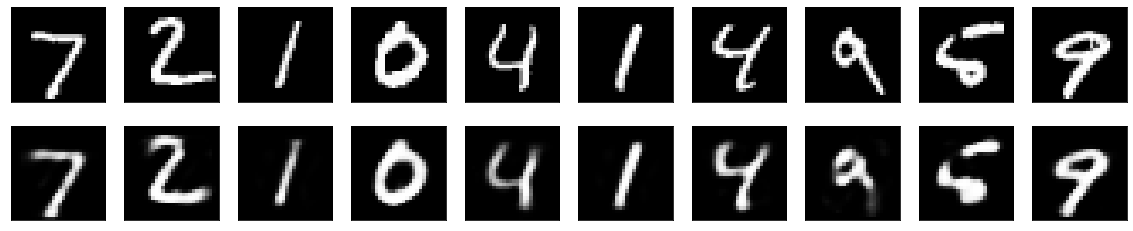

In [75]:
compare_digits(x_test, x_test_out)

Απ' ότι φαίνεται, παρότι ο αυτοκωδικοποιητής χάνει λίγο σε λεπτομέρεια (εμφανέστερα στο 8<sup>ο</sup>  ψηφίο που είναι ο αιρθμός $9$) κατορθώνει να μάθει σε ικανοποιητικό βαθμό τα χαρακτηριστικά της εισόδου του συγκερκιμένου dataset.

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηρισικά)

In [76]:
pd.set_option('display.max_columns', dim_h) #display 32 columns
pd.DataFrame(data=h[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
1,6.966670,1.680999,8.938732,3.929248,9.542408,4.616889,7.720593,3.195412,3.453934,6.408370,3.221150,7.583452,3.724428,11.857154,8.180934,8.296719,0.000000,1.155626,9.275470,4.098057,10.356335,1.016741,9.981777,3.887672,11.638451,5.477365,2.751546,10.717236,1.936682,13.111370,4.260716,1.674826
2,5.265272,17.919476,11.437515,12.901646,6.233283,4.414268,13.316796,8.815642,8.469339,13.679185,22.157127,2.464192,7.284698,8.849815,5.971058,12.874711,8.956287,2.795924,6.908791,3.362823,5.503702,3.191891,6.117896,11.344095,7.185418,3.580791,4.619034,7.571519,5.617908,1.740638,8.554164,11.657801
3,6.530215,9.161772,1.956945,3.746738,7.954413,3.377800,2.472965,1.732078,2.722024,4.991813,6.363460,4.438523,11.177858,7.372051,9.944806,3.295599,2.549701,4.387215,7.009080,1.874246,3.424398,5.482702,1.305973,6.202832,10.896663,3.212353,1.464973,7.215142,1.904830,2.471896,1.577166,4.596034
4,4.482086,12.718491,8.411665,10.366301,6.991455,14.041232,10.758852,6.760537,13.487429,12.449148,23.614393,13.364590,3.995180,27.518606,16.231998,18.858116,16.079329,13.601490,7.354185,11.492930,11.608614,6.876845,15.572298,6.241458,20.617012,11.398271,9.779122,16.015831,10.122988,9.131454,9.670052,10.424280
5,6.112158,7.523521,4.912581,6.214885,4.472421,5.242769,1.536234,5.359433,3.386742,5.942760,3.254771,4.966730,4.349121,11.375953,5.805092,10.565581,3.412895,10.210455,4.153190,10.580987,6.560143,4.143148,10.043373,6.203872,9.871112,3.965026,4.763206,2.951975,6.942167,13.307941,10.632990,10.052623
6,7.999117,10.653133,1.910041,4.203443,10.523159,4.048659,3.627867,4.260517,3.418747,5.112086,7.831925,7.346590,12.686472,11.492661,11.828334,3.579787,3.246932,4.268163,11.414111,3.131857,5.121731,7.031829,3.865254,7.239215,13.372479,5.031315,2.421378,7.665213,2.372335,3.031086,0.892938,7.823824
7,7.749084,6.908251,4.980024,5.627372,9.277809,3.078064,10.431072,8.410838,12.644304,8.256657,5.914006,4.635589,2.511271,7.145159,6.470399,6.390743,2.826161,6.787226,13.774322,12.337907,6.868064,5.492561,12.396632,8.318468,12.429679,2.190867,5.647591,5.795118,3.201512,11.517489,9.940665,3.153692
8,7.564785,5.555557,7.904352,8.633005,9.935455,1.451109,3.613085,1.327453,6.864939,9.881429,6.106476,6.400122,3.722943,6.112074,12.672108,5.214556,10.954936,6.087783,8.757390,9.044684,4.417514,4.848184,4.358220,4.993111,14.372489,9.348699,2.850161,3.725049,12.233275,8.428499,4.943329,12.508403
9,6.017779,18.431816,2.801841,15.057648,4.953630,0.888108,6.772167,9.306458,4.312195,4.040557,13.223960,11.223728,6.261302,19.334213,13.442491,9.414007,3.055849,18.321581,10.166203,12.965905,7.142176,5.729079,6.388288,12.595089,11.228434,7.005546,8.674584,9.195094,10.356105,14.268057,6.392457,10.274733
10,12.759141,2.035120,11.150134,4.023770,7.132868,9.259843,12.048365,10.237016,8.111617,11.918036,6.615331,11.563026,5.727267,20.399975,16.319393,11.416410,6.942783,7.667742,15.084344,7.407842,6.858293,9.480795,7.658426,5.882334,24.265358,4.811487,7.526971,9.614553,7.179088,12.725001,5.169626,8.141016


Οι αυτοκωδικοποιητές μαθαίνουν κατανεμημένες αναπαραστάσεις (distributed representations) της εισόδου τους. Συνεπώς αναμένουμε οι αναπαραστάσεις όμοιων ψηφιών στο επίπεδο κωδιοποίησης να είναι περισσότερό "κοντά". Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των $10$ πρώτων ψηφίων του συνόλου ελέγχου.

In [77]:
pd.DataFrame(data=cosine_similarity(h[0:10]), columns=range(1,11), index=range(1,11)).head(10)

,1,2,3,4,5,6,7,8,9,10
1,1.000000,0.701175,0.787745,0.838284,0.830822,0.813517,0.872658,0.793223,0.776426,0.911191
2,0.701175,1.000000,0.790627,0.858423,0.759394,0.786040,0.787625,0.784460,0.812619,0.752331
3,0.787745,0.790627,1.000000,0.818784,0.763888,0.986900,0.779231,0.832616,0.837008,0.851504
4,0.838284,0.858423,0.818784,1.000000,0.876465,0.834513,0.841217,0.855016,0.885917,0.898671
5,0.830822,0.759394,0.763888,0.876465,1.000000,0.780986,0.879887,0.860325,0.905247,0.861280
6,0.813517,0.786040,0.986900,0.834513,0.780986,1.000000,0.804866,0.843758,0.851436,0.877066
7,0.872658,0.787625,0.779231,0.841217,0.879887,0.804866,1.000000,0.834624,0.840661,0.885179
8,0.793223,0.784460,0.832616,0.855016,0.860325,0.843758,0.834624,1.000000,0.837029,0.875250
9,0.776426,0.812619,0.837008,0.885917,0.905247,0.851436,0.840661,0.837029,1.000000,0.833364
10,0.911191,0.752331,0.851504,0.898671,0.861280,0.877066,0.885179,0.875250,0.833364,1.000000


Αναμένουμε το 3<sup>ο</sup> και το 6<sup>ο</sup>  ψηφίο να είναι εγγύτερα (αριθμός $1$), όπως αντίστοιχα το 5<sup>ο</sup> και το 7<sup>ο</sup> (αριθμός $4$) και το 8<sup>ο</sup> και το 10<sup>ο</sup>  (αριθμός $9$). Ωστόσο από τον παραπάνω πίνακα παρατηρούμε ότι το 3<sup>ο</sup>  ψηφίο είναι εγγύτερα στο 10<sup>ο</sup>  (αριθμός $9$) με συντελεστή ομοιότητας $0.85$ ενώ είναι μακρύτερα από το 6<sup>ο</sup> (συντελεστής ομοιότητας $-0.08$). Από την άλλη όμως, το 6<sup>ο</sup> ψηφίο είναι εγγύτερα στο 3<sup>ο</sup> (σε σύγκριση με τα υπόλοιπα πάντα). Παρόμοιες παρατηρήσεις μπορούμε να κάνουμε για τα άλλα ζεύγη.

Καταλήγουμε στο συμπέρασμα ότι μπορεί ναι μεν η εκπαίδευση του αυτοκωδικοποιητή να ολοκληρώθηκε με χαμηλό σφάλμα εκπαίδευσης και γενίνευσης, ωστόσο η αναπαράσταση που έμαθε χρήζει βελτίωσης. Η ζητούμενη βελτίωση μπορεί να επιτευχθεί μεταβάλλοντας τα χαρακτηριστικά του αυτοκωδικοποιητή (μέγεθος κωδικοποίησης, συναρτήσεις (από)κωδικοποίησης, αλγόριθμος σφάλματος και εκπαίδευσης) αλλά και εξετάζοντας διαφορετικές αρχιτερκτονικές αυτοκωδικοποιητών, όπως θα δούμε παρακάτων

Πριν προχωρήσουμε, ας δούμε τη μέση τιμή των χαρακτηριστικών του υποπλήρη αυτοκωδικοποιητή 

In [78]:
print(h.mean())

8.93051


## Αραιός αυτοκωδικοποιητής

Στον **αραιό αυτοκωδικοποιητή** (*sparse autoencoder*) επιβάλλουμε όρο ποινής αραιότητας $\Omega(\mathbf{h})$ του επιπέδου κωδικοποίησης $\mathbf{h}$ στη διαδικασία μάθησης (παράμετρος *activity_regularizer* της κλάσης *Dense* του keras)

Στη συγκεκριμένη περίπτωση επιλέγουμε $L_1$ κανονικοποίηση με βάρος $\lambda=10^{-7}$, δηλαδή $\Omega(\mathbf{h}) = 10^{-7}||\mathbf{h}||$

In [0]:
sparse_autoencoder = Sequential([
    Dense(dim_h, activation='relu', 
          activity_regularizer=regularizers.l1(10e-7), 
          input_shape=(dim_x,)),
    Dense(dim_x, activation='sigmoid')
])


sparse_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Από τη στιγμή που έχουμε προσθέσει όρο ομαλοποίησης (αραιότητας), μπορούμε να αυξήσουμε τον αριθμό των εποχών σε $100$ χωρίς τον φόβο υπερπροσαρμογής.

In [0]:
sparse_autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 58us/step - loss: 0.2769 - val_loss: 0.2203
Epoch 2/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.2006 - val_loss: 0.1846
Epoch 3/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1769 - val_loss: 0.1672
Epoch 4/100
60000/60000 [==============================] - 3s 51us/step - loss: 0.1619 - val_loss: 0.1544
Epoch 5/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1510 - val_loss: 0.1450
Epoch 6/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1428 - val_loss: 0.1376
Epoch 7/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.1362 - val_loss: 0.1318
Epoch 8/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1310 - val_loss: 0.1272
Epoch 9/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1270 - val_loss: 0.1

Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσίαστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Το σφάλμα εκπαίδευσης ωστόσο είναι $0.11$, ελαφρώς μεγαλύτερο απ' ότι προηγουμένως ($0.09$). 

Όπως και πριν, ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [0]:
sparse_encoder = Sequential([
    sparse_autoencoder.layers[-2]
])

sparse_decoder = Sequential([
    sparse_autoencoder.layers[-1]
])

h_sparse = sparse_encoder.predict(x_test)
x_test_out_sparse = sparse_decoder.predict(h_sparse)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αραιού αυτοκωδικοποιητή

In [0]:
compare_digits(x_test, x_test_out_sparse)

Απ' ότι φαίνεται, ο αραιός αυτοκωδικοποιητής εμφανίζει παρόμοια συμπεριφορά με τον υποπλήρη, χάνοντας λίγο σε λεπτομέρεια (εμφανέστερα στο 8<sup>ο</sup>  ψηφίο που είναι ο αιρθμός $9$),  κατορθώνοντας όμως να μάθει σε ικανοποιητικό βαθμό τα χαρακτηριστικά της εισόδου του συγκερκιμένου dataset.

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηρισικά)

In [0]:
pd.DataFrame(data=h_sparse[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

Παρατηρούμε ότι οι τιμές που λαμβάνουν τα χαρακτηριστικά είναι πιο χαμηλές σε σύγκριση με την περίπτωση του υποπλήρη αποκωδικοποιητή, πράγμα που οφείλεται στνη επίδραση του όρου αραιότητας. 

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [0]:
pd.DataFrame(data=cosine_similarity(h_sparse[0:10]), columns=range(1,11), index=range(1,11)).head(10)

Παρατηρούμε καταρχήν πως οι ομοιότητες συνημιτόνου είναι μεγαλύτερες σε σύγκριση με την προηγούμενη περίπτωση. Αυτό οφείλεται  στην αραιότητα που επιβάλλει στις παραγόμενες αναπαστάσεις ο όρος ποινής, κάνοντάς τες να λαμβάνουν τιμές πιο κοντά στο $0$.

Παρότι το σφάλμα εκπαίδευσης ήταν ελαφρώς χειρότερο, παρατηρούμε ότι η αναπαράσταση που επιτύχαμε είναι καλύτερη. Για παράδειγμα, το πιο όμοιο στο 3<sup>ο</sup> ψηφίο είναι το 6<sup>ο</sup> (ομοιότητα $0.98$) και το αντίστοιχο ισχύει και για το  6<sup>ο</sup>  ψηφίο (και τα δύο απεικονίζουν τον αριθμό $1$). Αντίστοιχα συμπεράσματα μπορούν να βγούν και για τα υπόλοιπα ζεύγη ψηφίων (5<sup>ο</sup>, 7<sup>ο</sup> και 8<sup>ο</sup>, 10<sup>ο</sup>) αν οι ομοιότητές τους συγκριθούν με την περίπτωση του υποπλήρη αυτοκωδικοποιητή.



In [0]:
print(h_sparse.mean())

Τέλος, παρατηρούμε ότι η μέση τιμή των χαρακτηριστικών του αραιού αυτοκωδικοποιητή είναι χαμηλότερη σε σύγκριση με του  υποπλήρη ($2.88$ και $8.93$ αντίστοιχα)

## Αυτοκωδικοιητής απαλοιφής θορύβου

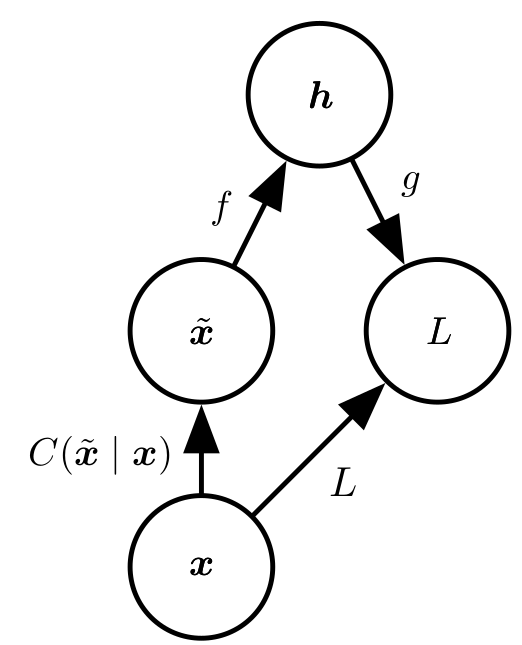

Σε αυτή την περίπτωση επιβάλλουμε στον αυτοκωδικοποιητή να μάθει τα χαρακτηριστικά της εισόδου $\mathbf{x}$ , "αλλοιώνοντάς" την μέσω της προσθήκης θορύβου κανονικής κατανομής με μέση τιμή $\mu=0$ και τυπική απόκλιση $\sigma = 1$: $\mathcal{N}(0, 1)$. Επίσης ορίζουμε τον βαθμό συνεισφοράς του θορύβου (noise factor) στα αρχικά δεδομένα ίσο με $n_f = 0.3$. Έχουμε δηλαδή:

$\widetilde{\mathbf{x}} = \mathbf{x} + 0.3\mathcal{N}(0, 1)$ 

In [0]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, 
                                                          size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, 
                                                        size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)

Ας δούμε τα $10$ πρώρα ψηφία του συνόλου ελέγχου μετά την προσθήκη του θορύβου

In [0]:
display_digits(x_test_noisy)

Το δίκτυο έχει την ίδια δομή με έναν υποπλήρη αυτοκωδικοποιητή

In [0]:
noisy_autoencoder = Sequential([
    Dense(dim_h, activation='relu', input_shape=(dim_x,)),
    Dense(dim_x, activation='sigmoid')
])


noisy_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Το εκπαιδεύουμε για ίδιο αριθμό εποχών

In [0]:
noisy_autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

**ΝΟΤΕ**

(Overfitting)
Στην αρχή το val_loss είναι σταθερό (ή μεγαλώνει) ενώ το loss μικραίνει. Αυτό σημαίνει ότι γίνεται overfitting. Δεν γίνεται γενίκευση.

Γενικά θέλουμε να πεφτουν οι δυο τιμές, και μάλιστα με όμοια κλίση.

Μια αντιμετώπιση είναι να προσθέσουμε παραπάνω χαρακτηριστικά (από 32 σε 64).

Μασ νοιάζει να πετυχαίνει ομοιότητα στα κοινά, ανομοιότητα στα όχι κοινά. 
Η τιμή της ομοιότητας δεν μας νοιάζει.


Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσίαστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση, με το αντίστοιχο σφάλμα να είναι στα ίδια επίπεδα με τον αραιό αυτοκωδικοποιητή (και ελαφρώς χειρότερο απ' ότι στον υποπλήρη αυτοκωδικοποιητή)

Ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [0]:
noisy_encoder = Sequential([
    noisy_autoencoder.layers[-2]
])

noisy_decoder = Sequential([
    noisy_autoencoder.layers[-1]
])

h_noisy = noisy_encoder.predict(x_test_noisy)
x_test_out_noisy = noisy_decoder.predict(h_noisy)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου (με θόρυβο) και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του αραιού αυτοκωδικοποιητή

In [0]:
compare_digits(x_test_noisy, x_test_out_noisy)

Απ' ότι φαίνεται, ο αυτοκωδικοποητής απαλοιφής θορύβου κατορθώνει να γενικεύσει, μιας και μπορεί να αναπαριστά τα ψηφία χωρίς θόρυβο (ωστόσο όχι τόσο καλά όσο οι προηγούμενοι δύο).

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [0]:
pd.DataFrame(data=h_noisy[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

Εδώ δεν υπάρχει ποινή αραιοητας, οπότε τα χαρακτηριστικά λαμβάνουν τιμές αντίστοιχες με τον υποπλήρη αυτοκωδικοποιητή. 

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [0]:
pd.DataFrame(data=cosine_similarity(h_noisy[0:10]), columns=range(1,11), index=range(1,11)).head(10)

Παρότι δεν υπάρχει ποινή αραιότητας, οι ομοιότητες συνημιτόνου είναι ακόμα μεγαλύτερες σε σύγκριση με τις δύο προηγούμενες περιπτώσεις. Επίσης, πάλι το  3<sup>ο</sup> και το 6<sup>ο</sup>  ψηφίο είναι πιο όμοια μεταξύ τους και το ίδιο ισχύει σχεδόν για όλα τα υπόλοιπα ζεύγη ψηφίων  (5<sup>ο</sup>, 7<sup>ο</sup> και 8<sup>ο</sup>, 10<sup>ο</sup> - κάντε τις συγκρίσεις με τις προηγούμενες περιπτώσεις).


## Βαθύς Αυτοκωδικοποιητής

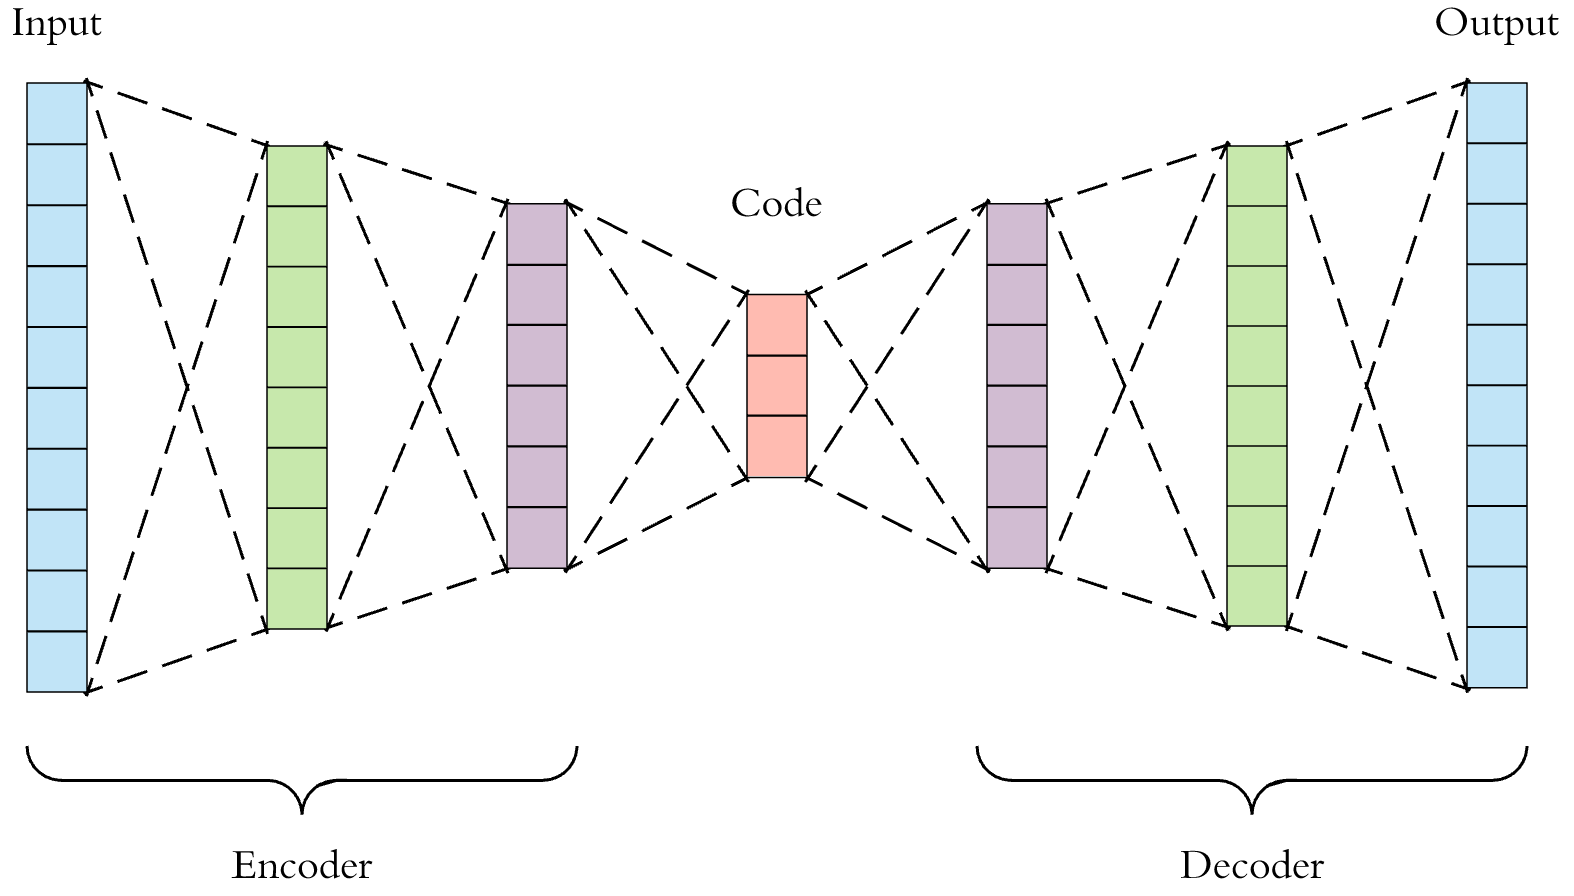

Στους **βαθείς αυτοκωδικοποιητές** (*deep autoencoders*) οι συναρτήσεις (από)κωδικοποίησης δεν αποτελούνται από ένα μόνο επίπεδο αλλά από περισσότερα. Στο παράδειγμα που εξετάζουμε, συνάρτηση κωδικοποίησης αποτελείται από $3$ επίπεδα με διαστάσεις $128, 64$ και $32$ αντίστοιχα και με συνάρτηση ενεργοποίησης την ReLU. Ίδιο αριθμό  επίπεδων (με ανάστροφη σειρά) έχει η συνάρτηση αποκωδικοποίησης, με το τελευταίο να έχει συνάρτηση ενεργοποίησης τη σιγμοειδή (για να "σπάσει" τη συμμετρία). Στη γενικότερη περίπτωση ωστόσο, δεν είναι υποχρεωτικό οι συναρτήσεις (απο)κωδικοποίησης να έχουν ίδιο αριθμό επιπέδων


In [0]:
layer1_dim = 128
layer2_dim = 64

deep_autoencoder = Sequential([
    Dense(layer1_dim, activation='relu', input_shape=(dim_x,)),
    Dense(layer2_dim, activation='relu'),
    Dense(dim_h, activation='relu'),
    
    Dense(layer2_dim, activation='relu'),
    Dense(layer1_dim, activation='relu'),
    Dense(dim_x, activation='sigmoid')
])


deep_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Εκπαιδεύουμε για 100 εποχές

In [0]:
deep_autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

**ΝΟΤΕ**

Πετυχαίνω μείωση διαστατικότητας από 28*28 σε 32.

Πευχαίνω εξαγωγή χαρακτηριστικών γιατί τα όμοια στον χώρο των 28*28 είναι επίσης κοντά στον νέο μειωμένο χώρο των 32 χαρακτηριστικών.

Παρατηρούμε ότι ούτε σε αυτή την περίπτωση παρουσίαστηκαν φαινόμενα υπερπροσαρμογής στην εκπαίδευση. Ωστόσο το σφάλμαε εκπάιδευσης και επαλήθευσης είναι χαμηλότερο απ'  ότι σε όλες τις άλλες περιπτώσεις

Ορίζουμε τα δίκτυα του κωδικοποιητή και του αποκωδικοποιητή.

In [0]:
deep_encoder = Sequential([
    deep_autoencoder.layers[0],
    deep_autoencoder.layers[1],
    deep_autoencoder.layers[2]
])

deep_decoder = Sequential([
    deep_autoencoder.layers[-3],
    deep_autoencoder.layers[-2],
    deep_autoencoder.layers[-1]
])

h_deep = deep_encoder.predict(x_test)
x_test_out_deep = deep_decoder.predict(h_deep)

Εμφανίζουμε στην πρώτη σειρά τα δέκα πρώτα ψηφία του συνόλου ελέγχου  και στη δεύτερη σειρά, τα ίδια ψηφία όπως προκύπτουν από την έξοδο του βαθύ αυτοκωδικοποιητή.

In [0]:
compare_digits(x_test, x_test_out_deep)

Εκ πρώτης όψεως, ο βαθύς αυτοκωδικοποιητής έχει μάθει την καλύτερη αναπαράσταση σε σχέση με τους υπόλοιπους. 

Ας δούμε την αντίστοιχη κωδικοποίηση των $10$ πρώτων ψηφίων ($32$ χαρακτηριστικά)

In [0]:
pd.DataFrame(data=h_deep[0:10], columns=range(1,dim_h+1), index=range(1,11)).head(10)

Ας υπολογίσουμε την ομοιότητα συνημιτόνου για τις αναπαραστάσεις των 10 πρώτων ψηφίων του συνόλου ελέγχου.

In [0]:
pd.DataFrame(data=cosine_similarity(h_deep[0:10]), columns=range(1,11), index=range(1,11)).head(10)

Παρατηρούμε ότι σε αυτή την περίπτωση τα 3 ζεύγη όμοιων ψηφίων (3<sup>ο</sup>, 6<sup>ο</sup> - 5<sup>ο</sup>, 7<sup>ο</sup> - 8<sup>ο</sup>, 10<sup>ο</sup>) είναι ανάμεσα στα πιο όμοια μεταξύ τους

## Τσεκ πόσα μηδενικά με  64 χαρακτηριστικά στην έξοδο (Άσκηση)

## Προαιρετικές Ασκήσεις

### Υποπλήρης Αυτοκωδικοποιητής

1. Αντιστρέψετε τις συναρτήσεις (απο)κωδικοποίησης. Τι παρατηρείτε;
2. Χρησιμοποιείστε την ίδια συνάρτηση κωδικοποίησης και αποκωδικοποίησης (λχ τη relu). Τι παρατηρείτε;


### Αραιός Αυτοκωδικοποιητής

1. Δοκιμάστε να αυξήσετε το βάρος της ποινής αραιότητας. Τι παρατηρείτε;


### Αυτοκωδικοποιητής απαλοιφής θορύβου

1. Δοκομάστε να μεταβάλλετε (αυξήσετε/μειώσετε) το συντελεστή θορύβου. Τι παρατηρείτε;


### Βαθύς αυτοκωδικοποιητής

1. Δοκιμάστε να χρησιμοποιήσετε διαφορετικές συναρτήσεις στο επίπεδο αποκωδικοποίησης. Τι παρατηρείτε;

## Επιπρόσθετο υλικό

1. https://blog.keras.io/building-autoencoders-in-keras.html